In [7]:

import networkx as nx
# from simulator import CovertGenerator, DarkGenerator
import numpy as np
import pandas as pd
import json, os, sys
from tqdm import trange, tqdm
from utility import read_gml, write_gml, getRobustness, HXA

# sys.path.append(os.path.dirname(__file__) + os.sep + '../')
sys.path.append('../')
from FINDER import FINDER

maping = {
    1: '911.gml', 2: 'DOMESTICTERRORWEB.gml', 
    3: 'suicide.gml', 4: 'HAMBURG_TIE_YEAR.gml',
    5: 'HEROIN_DEALING.gml', 6: 'ITALIAN_GANGS.gml',
    7: 'MAIL.gml', 8: 'NDRANGHETAMAFIA_2M.gml',
    9: 'PREVERE1MODE.gml', 10: 'RHODESBOMBING.gml', 11:  'SWINGERS_club.gml',
}

ImportError: dlopen(../FINDER.cpython-37m-darwin.so, 0x0002): tried: '../FINDER.cpython-37m-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS../FINDER.cpython-37m-darwin.so' (no such file), '/Users/zhangxiangxian/.pyenv/versions/3.7.17/lib/../FINDER.cpython-37m-darwin.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/zhangxiangxian/.pyenv/versions/3.7.17/lib/../FINDER.cpython-37m-darwin.so' (no such file), '/opt/homebrew/lib/../FINDER.cpython-37m-darwin.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/../FINDER.cpython-37m-darwin.so' (no such file), '/Users/zhangxiangxian/.pyenv/versions/3.7.17/lib/../FINDER.cpython-37m-darwin.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/zhangxiangxian/.pyenv/versions/3.7.17/lib/../FINDER.cpython-37m-darwin.so' (no such file), '/opt/homebrew/lib/../FINDER.cpython-37m-darwin.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/../FINDER.cpython-37m-darwin.so' (no such file), '/opt/homebrew/lib/../FINDER.cpython-37m-darwin.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/../FINDER.cpython-37m-darwin.so' (no such file), '/Users/zhangxiangxian/.pyenv/versions/3.7.17/lib/../FINDER.cpython-37m-darwin.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/zhangxiangxian/.pyenv/versions/3.7.17/lib/../FINDER.cpython-37m-darwin.so' (no such file), '/opt/homebrew/lib/../FINDER.cpython-37m-darwin.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/../FINDER.cpython-37m-darwin.so' (no such file), '/Users/zhangxiangxian/.pyenv/versions/3.7.17/lib/../FINDER.cpython-37m-darwin.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/zhangxiangxian/.pyenv/versions/3.7.17/lib/../FINDER.cpython-37m-darwin.so' (no such file), '/opt/homebrew/lib/../FINDER.cpython-37m-darwin.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/../FINDER.cpython-37m-darwin.so' (no such file), '/opt/homebrew/lib/../FINDER.cpython-37m-darwin.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/../FINDER.cpython-37m-darwin.so' (no such file), '/usr/lib/../FINDER.cpython-37m-darwin.so' (no such file, not in dyld cache), '../FINDER.cpython-37m-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/Users/zhangxiangxian/Desktop/FINDER_deploy/FINDER.cpython-37m-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/zhangxiangxian/Desktop/FINDER_deploy/FINDER.cpython-37m-darwin.so' (no such file), '/Users/zhangxiangxian/Desktop/FINDER_deploy/FINDER.cpython-37m-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64'))

## Heuristic based (Empirical)

In [6]:
if not os.path.exists(f"../empirical_data/hxa_node_hist"):
    os.mkdir(f"../empirical_data/hxa_node_hist")

if not os.path.exists(f"../empirical_data/hxa_reward_hist"):
    os.mkdir(f"../empirical_data/hxa_reward_hist")

for idx, file in maping.items():
    g = nx.read_gml("../empirical_data/" + file)
    node_mapping = {node: i for i, node in enumerate(g.nodes())}
    g = nx.relabel_nodes(g, node_mapping)

    hxa_dct, reward_dct = dict(), dict()
    for method in ['HDA', 'HBA', 'HCA', 'HPRA']:
        sol, reward = HXA(g=g, method=method)
        hxa_dct[method] = sol
        reward_dct[method] = (np.cumsum(reward) / g.number_of_nodes()).tolist()

    with open(f"../empirical_data/hxa_node_hist/g_{idx}.json", "w") as json_file:
        json.dump(hxa_dct, json_file) 
    with open(f"../empirical_data/hxa_reward_hist/g_{idx}.json", "w") as json_file:
        json.dump(reward_dct, json_file)
    

## FINDER based (Empirical)

In [4]:
if not os.path.exists(f"../empirical_data/finder_node_hist"):
    os.mkdir(f"../empirical_data/finder_node_hist")

if not os.path.exists(f"../empirical_data/finder_reward_hist"):
    os.mkdir(f"../empirical_data/finder_reward_hist")




def main():
    dqn = FINDER()
    # model_file = './models/Model_barabasi_albert/nrange_200_200_iter_154500.ckpt'
    model_file = './models/Model_dark/nrange_200_200_iter_464100.ckpt'

    for i in range(100):
        with open(f"data/dark/finder_node_hist/g_{i}.txt", 'w') as fout:
            val, sol = dqn.Evaluate(f"data/dark/g_{i}", model_file)
            for i, s in enumerate(sol):
                fout.write(f'{i}, {s}\n')
            fout.flush()
        print("done")

if __name__=="__main__":
    main()


## Heuristic based (Synthetic)

In [ ]:
gtype = "ba"
for i in trange(100):
    hxa_dct, reward_dct = {}, {}
    g = read_gml(data_dir=f"./{gtype}/", file_name=f"g_{i}")
    G = g.copy()
    for method in ['HDA', 'HBA', 'HCA', 'HPRA']:
        sol, reward = HXA(g=g, method=method)
        hxa_dct[method] = sol
        reward_dct[method] = (np.cumsum(reward) / g.number_of_nodes()).tolist()
        
    with open(f"./{gtype}/hxa_node_hist/g_{i}.json", "w") as json_file:
        json.dump(hxa_dct, json_file) 
    with open(f"./{gtype}/hxa_reward_hist/g_{i}.json", "w") as json_file:
        json.dump(reward_dct, json_file)

## FINDER 

In [71]:
for i in trange(10):
    finder_dct = dict()
    reward_lst = []
    g = read_gml(data_dir="./ba/", file_name=f"g_{i}")
    G = g.copy()
    df = pd.read_csv(f"./ba/finder_node_hist/g_{i}.txt", header=None).rename(columns={0: "round", 1: "node"})
     
    for row_idx, (round, node) in df.iterrows():
        reward_lst.append(getRobustness(g, G, int(node)))
        
    for _ in range(g.number_of_nodes() - len(reward_lst)):
        GCCsize = len(max(nx.connected_components(g), key=len))
        reward_lst.append(1 - 1/GCCsize)

    reward_lst = (np.cumsum(reward_lst) / g.number_of_nodes()).tolist()

    with open(f"./ba/finder_reward_hist/g_{i}.json", "w") as json_file:
        json.dump(reward_lst, json_file)


100%|██████████| 10/10 [00:00<00:00, 12.79it/s]


## FINDER action w.r.t HXA

In [144]:
from scipy.stats import percentileofscore

rank_dct = {
    "HDA": [], "HBA": [], 
    "HCA": [], "HPRA": []
}

for i in range(100):
    G = read_gml(data_dir="./ba/", file_name=f"g_{i}")
    df = pd.read_csv(f"./ba/finder_node_hist/g_{i}.txt", header=None).rename(columns={0: "round", 1: "node"})    
    
    rank_lst = []
    for _, (round, n) in df.iterrows():
        try:
            for method in ['HDA', 'HBA', 'HCA', 'HPRA']:
                if method == 'HDA':
                    dc = nx.degree_centrality(G)
                elif method == 'HBA':
                    dc = nx.betweenness_centrality(G)
                elif method == 'HCA':
                    dc = nx.closeness_centrality(G)
                elif method == 'HPRA':
                    dc = nx.pagerank(G)

                rank = percentileofscore(list(dc.values()), dc[n])
                rank_lst.append(rank)

            removed = [n for n in G.neighbors(int(n))] + [int(n)]
            for n in removed:
                G.remove_node(n)

        except:
            pass
    rank_dct[method].append(rank_lst)

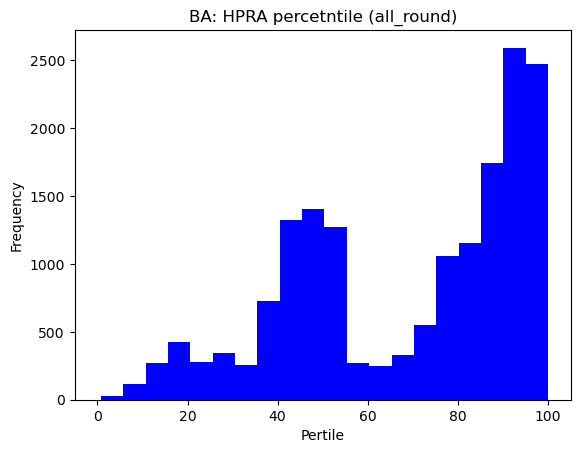

In [150]:
for method in ['HDA', 'HBA', 'HCA', 'HPRA']:
    avg_lst = []
    for rank_lst in rank_dct[method]:
        for i in rank_lst:
            avg_lst.append(i)
#         avg_lst.append(np.mean(rank_lst))
    plt.xlabel('Pertile')
    plt.ylabel('Frequency')
    
    plt.hist(avg_lst, bins=20, color="blue")
    plt.title(f"BA: {method} percetntile (all_round)")
    plt.savefig(f"./ba/{method}_all_round.png") 
    